<h1 style="text-align:center;">Speech Recognition of Numbers from 0 to 12</h1>
The project was created as a part of Data Science series of PDX Data Science Meetup Group.
Training dataset: 719 WAV files with numbers spoken by different people. 
Testing dataset: 101 file.
Two main parts:
<ol>
    <li>Creating images of Signal traces and spectrogramms
    <li>Using TensorFlow, recognizing the spoken numbers.
</ol>

Workflow for first part:
- loading the WAV file
- filtering 500:3200 Hz of signal
- finding the signal interval between silence
- plot amplitude-time curve
- resample signal to have them all same sampled
- plotting the spectrogramm
- saving PNG files with both amplitude-time curve and spectrogramm

Workflow for second part:
- creating Convolutional Neural Network
- training the CNN model
- testing the CNN model

In [ ]:
import scipy.io.wavfile as wv
import os
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy.signal as ss
import pandas as pd
import seaborn as sns


Some functions will use

In [ ]:
###  check is folders exists, if not - create
##
def folders (FoldersList):
    for fold in FoldersList:
        
        if (os.path.isdir(fold)==0):
            os.mkdir(fold)
#
# This function find the start and end of the spoken number, defining the silence
# before and after.

def signal_interval(SampleRate, data_f, step, step_coef, file):
    over_std = np.where(abs(data_f)>data_f.std())[0]
    N, = over_std.shape
    
    over_std_cont = np.zeros ((len(data_f),1))
    n = 0
    while (n<N-step):
        if over_std[n+step]-over_std[n]<=step*step_coef: #where is no gap
            over_std_cont[over_std[n]:over_std[n+step]]=1
        n+=1
    diff = over_std_cont[:-1]-over_std_cont[1:]
    starts = np.where (diff==-1)[0] 
    ends = np.where (diff==1)[0]
    
    if len(starts)<len(ends):
        starts.insert(0, 0) #first start will be the beginnibg of the trace
    elif len(starts)>len(ends):
        ends.insert(len(data), -1) #last start is end of trace
    durations = ends-starts
    start_p = starts[durations.argmax()]
    end_p = ends[durations.argmax()]

    return start_p, end_p 

[Text(0, 0.5, 'Amplitude')]

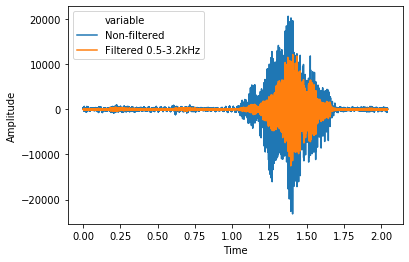

In [ ]:
#Let's get one WAV file and see how the Amplitude and Spectrogram looks like
path = os.getcwd()
WAV_Dir = 'samples'
Destin_Dir = 'TestSet_png'
Signal_Interval_Folder = 'Signal_Interval'
filelist = os.listdir(os.path.join(os.getcwd(),WAV_Dir))
folders ([Destin_Dir, Signal_Interval_Folder])
file = filelist[0]

#reading WAV file 
SampleRate,data = wv.read(os.path.join(path, WAV_Dir, file))
#files are different, can be 1D, can be 2D
if len(data.shape) ==2 : data = data[:,0]
time_in_sec= np.arange(1, len(data)+1)/SampleRate

#filtering
f_cutoff = [500, 3200]
Wn = [f_cutoff[0] / (SampleRate/2) , f_cutoff[1] / (SampleRate/2)]
b, a = ss.iirfilter(1, Wn, ftype='butter', btype='bandpass')
data_f = ss.filtfilt(b, a, data)

###Plotting non-filtered vs filtered data with Seaborn

pd_data = pd.DataFrame({'Non-filtered': data, 'Filtered 0.5-3.2kHz': data_f, 'Time': time_in_sec})
ax = sns.lineplot(x='Time', y='value', hue='variable', data=pd.melt(pd_data, ['Time']))
ax.set(ylabel = "Amplitude")



<h2>Start and end of signal with signal_interval function</h2>
the function signal_interval has two adjustable parameters 
let's play with parameters and plot results

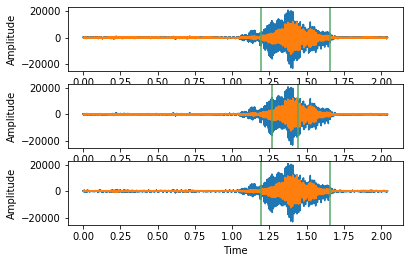

In [ ]:
###start and end of signal with signal_interval function

plt.figure()

plt.subplot(3,1,1)
ax = sns.lineplot(x='Time', y='value', hue='variable', data=pd.melt(pd_data, ['Time']), legend = False)
ax.set(ylabel = "Amplitude")
step = 10
step_coef = 80
start_p, end_p = signal_interval(SampleRate, data_f, step, step_coef, file)
plt.axvline(start_p/SampleRate, c = "#55a868")
plt.axvline(end_p/SampleRate, c = "#55a868")

plt.subplot(3,1,2)
ax = sns.lineplot(x='Time', y='value', hue='variable', data=pd.melt(pd_data, ['Time']), legend = False)
ax.set(ylabel = "Amplitude")
step = 2
step_coef = 30
start_p, end_p = signal_interval(SampleRate, data_f, step, step_coef, file)
plt.axvline(start_p/SampleRate, c = "#55a868")
plt.axvline(end_p/SampleRate, c = "#55a868")

plt.subplot(3,1,3)
ax = sns.lineplot(x='Time', y='value', hue='variable', data=pd.melt(pd_data, ['Time']), legend = False)
ax.set(ylabel = "Amplitude")
step = 20
step_coef = 50
start_p, end_p = signal_interval(SampleRate, data_f, step, step_coef, file)
plt.axvline(start_p/SampleRate, c = "#55a868")
plt.axvline(end_p/SampleRate, c = "#55a868")


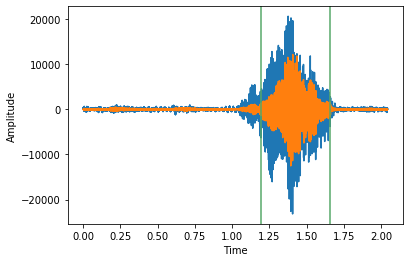

In [ ]:
ax = sns.lineplot(x='Time', y='value', hue='variable', data=pd.melt(pd_data, ['Time']), legend = False)
ax.set(ylabel = "Amplitude")
step = 20
step_coef = 50
start_p, end_p = signal_interval(SampleRate, data_f, step, step_coef, file)
plt.axvline(start_p/SampleRate, c = "#55a868")
plt.axvline(end_p/SampleRate, c = "#55a868")


<h2 style="text-align:center;">Spectrogram </h2>

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal.
After figuring the start and the end of the spoken number, the "silence" before and after can be cut out. The resulting signals will be all different duration. Before plotting the spectrogram, it's convenient to resample them, so they would be all same length (in dots).

In [ ]:
###resampling###
Resampling = 10000
data_res = ss.resample(data_f[start_p:end_p], Resampling)
SampleRate_res = Resampling/(end_p-start_p)*SampleRate

Text(0.5, 15.0, 'Time, sec')

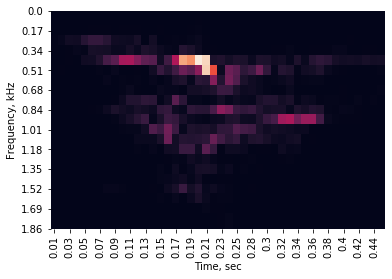

In [ ]:
f, t, Sxx = ss.spectrogram(data_res, fs = SampleRate_res)
Spec = pd.DataFrame(data = Sxx, columns =np.around(t,2), index = np.around(f/1000,2)) #frequency in kHz
LowerSpec = Spec[Spec.index<2]
sns.heatmap(LowerSpec, cbar=False)
plt.ylabel('Frequency, kHz')
plt.xlabel('Time, sec')

<h2 style="text-align:center;"> Automatization </h2>
Automatized for all files in the folder, graphics based on matplotlib without seaborn (to make it faster)

In [ ]:
def signal_interval_with_save(SampleRate, data_f, step, step_coef, file):
    over_std = np.where(abs(data_f)>data_f.std())[0]
    N, = over_std.shape
    
    over_std_cont = np.zeros ((len(data_f),1))
    n = 0
    while (n<N-step):
        if over_std[n+step]-over_std[n]<=step*step_coef: #where is no gap
            over_std_cont[over_std[n]:over_std[n+step]]=1
        n+=1
    diff = over_std_cont[:-1]-over_std_cont[1:]
    starts = np.where (diff==-1)[0] 
    ends = np.where (diff==1)[0]
    
    if len(starts)<len(ends):
        starts.insert(0, 0) #first start will be the beginning of the trace
    elif len(starts)>len(ends):
        ends.insert(len(data), -1) #last start is end of trace
    durations = ends-starts
    start_p = starts[durations.argmax()]
    end_p = ends[durations.argmax()]
    
    ###plotting###
    plt.figure()
    for n in range(N):
        plt.axvline(over_std[n])
    plt.plot(data_f, 'k')
    plt.axvline(start_p, color = 'r')
    plt.axvline(end_p, color = 'r')
    plt.savefig(os.path.join(path, 'Signal_Interval', file+'.png'))
    plt.close('all')
    
    return start_p, end_p

def to_png(SampleRate, data, file):
    #filtering
    f_cutoff = [500, 3200]
    Wn = [f_cutoff[0] / (SampleRate/2) , f_cutoff[1] / (SampleRate/2)]
    b, a = ss.iirfilter(1, Wn, ftype='butter', btype='bandpass')
    data_f = ss.filtfilt(b, a, data)

    #start and end of signal
    start_p, end_p = signal_interval(SampleRate, data_f, 10, 80, file)
    
    ###resampling###
    Resampling = 10000
    data_res = ss.resample(data_f[start_p:end_p], Resampling)
    SampleRate_res = Resampling/(end_p-start_p)*SampleRate

    #spectrogramm###
    plt.subplot(1,2,1)
    f, t, Sxx = ss.spectrogram(data_res, fs = SampleRate_res)
    plt.pcolormesh(t, f, Sxx, cmap=cm.gray)
    plt.xlim(t[0],t[-1])
    plt.ylim(500,3200)
    plt.yscale('log')
    plt.axis('off')
    plt.margins(0.0)

    ###trace###
    plt.subplot(1,2,2)
    plt.plot(data_res, 'k')
    plt.axis('off')
    plt.margins(0.0)
    plt.savefig(os.path.join(path, Destin_Dir, file+'.png'), bbox_inches="tight", cmap='gray')
    plt.close('all')

In [ ]:
path = os.getcwd()
WAV_Dir = 'numbers_test'
filelist = os.listdir(os.path.join(path,WAV_Dir))
Destin_Dir = 'TestSamples'
Signal_Interval_Folder = 'Signal_Interval'
folders ([Destin_Dir, Signal_Interval_Folder])

for file in filelist:
    SampleRate,data = wv.read(os.path.join(path, WAV_Dir, file))
    to_png(SampleRate, data, file)